Adam Ten Hoeve  
COMP 4448  
Final Project Notebook  


For this project, I have been tasked with finding a dataset that is applicable for classification. For this task, I am using the Glass Classification dataset from Kaggle which can be found [here](https://www.kaggle.com/uciml/glass).

This dataset contains 10 attributes, including an id. The response is the type of glass, which is of 7 possible catagories.

Attribute Information:
  
Id number: 1 to 214  
RI: refractive index  
Na: Sodium (unit measurement: weight percent in corresponding oxide, as are attributes 4-10)  
Mg: Magnesium  
Al: Aluminum  
Si: Silicon  
K: Potassium  
Ca: Calcium  
Ba: Barium  
Fe: Iron  
Type of glass: (class attribute)  
-- 1 buildingwindowsfloatprocessed  
-- 2 buildingwindowsnonfloatprocessed  
-- 3 vehiclewindowsfloatprocessed  
-- 4 vehiclewindowsnonfloatprocessed (none in this database)  
-- 5 containers  
-- 6 tableware  
-- 7 headlamps  

In [1]:
# Load necesary libraries
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.feature_selection import RFECV

import torch
from torch import nn

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

We'll start by loading in the data and doing some quick data exploration.

In [2]:
# Read in the data
df = pd.read_csv("glass.csv", header=0)
df.head()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
0,1.52101,13.64,4.49,1.10,71.78,0.06,8.75,0.0,0.0,1
1,1.51761,13.89,3.60,1.36,72.73,0.48,7.83,0.0,0.0,1
2,1.51618,13.53,3.55,1.54,72.99,0.39,7.78,0.0,0.0,1
3,1.51766,13.21,3.69,1.29,72.61,0.57,8.22,0.0,0.0,1
4,1.51742,13.27,3.62,1.24,73.08,0.55,8.07,0.0,0.0,1


In [3]:
# All of the features are continuous, so we can look at descriptive statistics.
df.describe()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe,Type
count,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000,214.000000
mean,1.518365,13.407850,2.684533,1.444907,72.650935,0.497056,8.956963,0.175047,0.057009,2.780374
std,0.003037,0.816604,1.442408,0.499270,0.774546,0.652192,1.423153,0.497219,0.097439,2.103739
min,1.511150,10.730000,0.000000,0.290000,69.810000,0.000000,5.430000,0.000000,0.000000,1.000000
25%,1.516523,12.907500,2.115000,1.190000,72.280000,0.122500,8.240000,0.000000,0.000000,1.000000
50%,1.517680,13.300000,3.480000,1.360000,72.790000,0.555000,8.600000,0.000000,0.000000,2.000000
75%,1.519157,13.825000,3.600000,1.630000,73.087500,0.610000,9.172500,0.000000,0.100000,3.000000
max,1.533930,17.380000,4.490000,3.500000,75.410000,6.210000,16.190000,3.150000,0.510000,7.000000


In [4]:
# Look for missing values
df.isnull().sum()

RI      0
Na      0
Mg      0
Al      0
Si      0
K       0
Ca      0
Ba      0
Fe      0
Type    0
dtype: int64

In [5]:
# Split the data into a training, validation and test sets
X = df.drop("Type", axis=1)
y = df["Type"]

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_train, X_valid, y_train, y_valid = train_test_split(X_temp, y_temp, test_size=0.2, random_state=0)

print(X_train.shape)
print(y_train.shape)
print(X_valid.shape)
print(y_valid.shape)
print(X_test.shape)
print(y_test.shape)

(136, 9)
(136,)
(35, 9)
(35,)
(43, 9)
(43,)


In [6]:
# Let's take a look at the distributions of these values.
ProfileReport(X_train)

D:\Anaconda3\lib\site-packages\pandas_profiling\describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


Number of variables,10
Number of observations,136
Total Missing (%),0.0%
Total size in memory,10.8 KiB
Average record size in memory,80.9 B
Numeric,10
Categorical,0
Boolean,0
Date,0
Text (Unique),0
Rejected,0


Text(0.5, 1.0, 'Histogram of Glass Types')

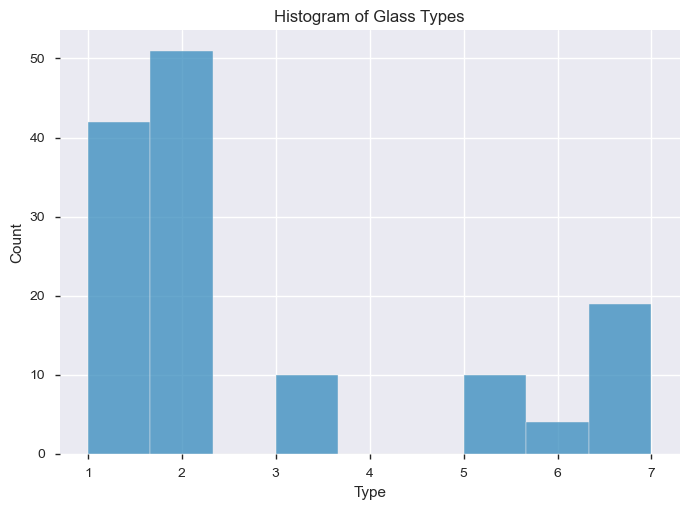

In [7]:
fig, ax = plt.subplots(1, 1)
sns.histplot(y_train, ax=ax)
ax.set_title("Histogram of Glass Types")

From the profile, we can gather a few conclusions:

* There is an unequal spread of glass types within the data, in particular that the first two types of glass have many more occurances than the other types. This could lead to our eventual models overpredicting on those common classes, so we will have to keep an eye out for that.
* We see that the features Ri and Ca are highly correlated, meaning that multicollinearity may be present in the dataset. We may be able to remove one of those features without significantly impacting the predictive power of the models.
* Some of the features (such as Mg, Ba, and Fe) are heavily skewed towards 0, with only a small amount being nonzero. That may lead to those features being less useful for eventually predicting the different types of glass.
* Some other variables (Si and Al) may follow a normal distribution.

In [8]:
plt.subplots_adjust(hspace=0.3, wspace=0.3)

<Figure size 800x550 with 0 Axes>

Text(0.5, 0, '')

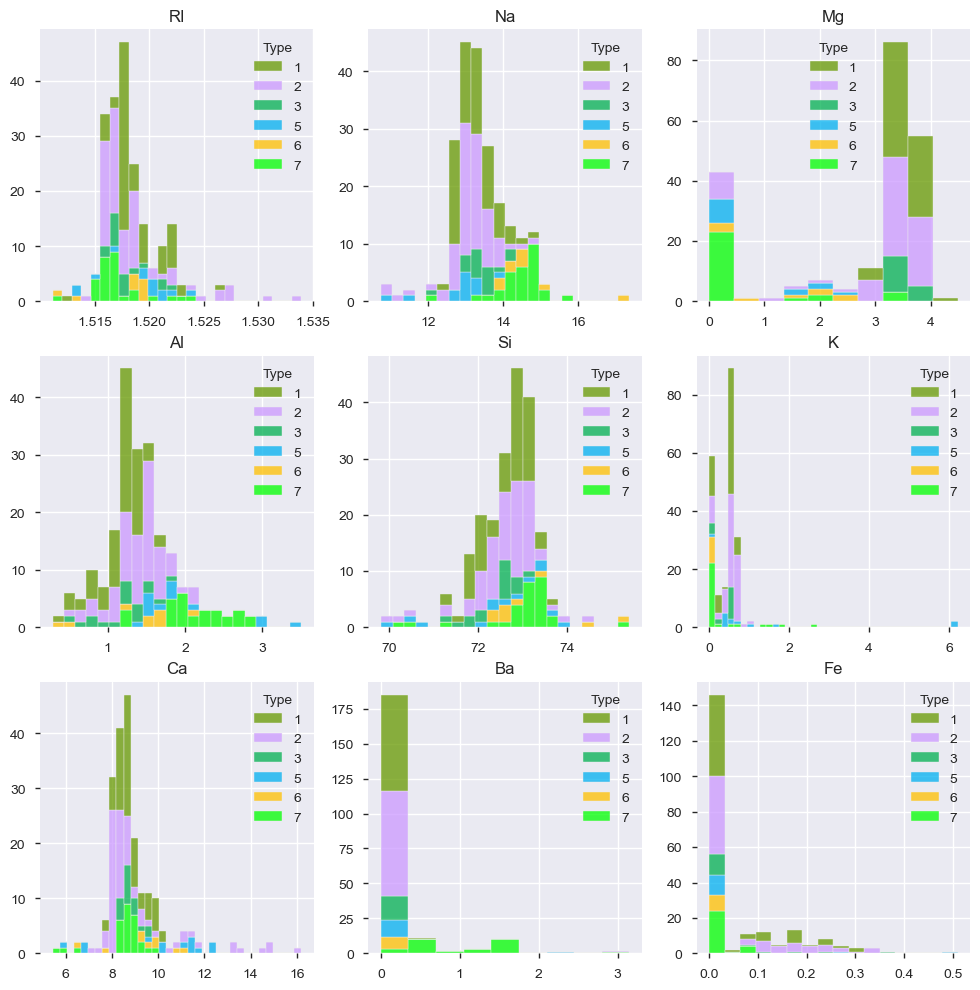

In [9]:
# Create distrubtion plots for the continuous features
fig, ax = plt.subplots(3, 3, figsize=(12, 12))
color_palette = ['#669900', '#CC99FF', '#00B050', '#00B0F0', '#FFC000', '#00FF00']

sns.histplot(x="RI", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[0, 0])
ax[0, 0].set_title("RI")
ax[0, 0].set_ylabel("")
ax[0, 0].set_xlabel("")

sns.histplot(x="Na", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[0, 1])
ax[0, 1].set_title("Na")
ax[0, 1].set_ylabel("")
ax[0, 1].set_xlabel("")

sns.histplot(x="Mg", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[0, 2])
ax[0, 2].set_title("Mg")
ax[0, 2].set_ylabel("")
ax[0, 2].set_xlabel("")

sns.histplot(x="Al", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[1, 0])
ax[1, 0].set_title("Al")
ax[1, 0].set_ylabel("")
ax[1, 0].set_xlabel("")

sns.histplot(x="Si", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[1, 1])
ax[1, 1].set_title("Si")
ax[1, 1].set_ylabel("")
ax[1, 1].set_xlabel("")

sns.histplot(x="K", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[1, 2])
ax[1, 2].set_title("K")
ax[1, 2].set_ylabel("")
ax[1, 2].set_xlabel("")

sns.histplot(x="Ca", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[2, 0])
ax[2, 0].set_title("Ca")
ax[2, 0].set_ylabel("")
ax[2, 0].set_xlabel("")

sns.histplot(x="Ba", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[2, 1])
ax[2, 1].set_title("Ba")
ax[2, 1].set_ylabel("")
ax[2, 1].set_xlabel("")

sns.histplot(x="Fe", hue="Type", multiple="stack", data=df, fill=True, palette=color_palette, ax=ax[2, 2])
ax[2, 2].set_title("Fe")
ax[2, 2].set_ylabel("")
ax[2, 2].set_xlabel("")

# fig.suptitle("Boxplots of Continuous Features")

For many of those models, it can be helpful to have consistant units between the different features. So we will scale our data to get everything into the same units. We will use the MinMaxScaler from Sklearn, as it doesn't change the underlying distributions of the data.

In [10]:
# Create a scaler and fit it to the data
scaler = MinMaxScaler()
scaler.fit(X_train)
# Scale the training, validation and test data
X_train = pd.DataFrame(scaler.transform(X_train), columns=X_train.columns)
X_valid = pd.DataFrame(scaler.transform(X_valid), columns=X_valid.columns)
X_test = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns)

Now let's start modelling some of our data. We have 6 different possible labels, so we will need to use multiclass classification methods. Some possible methods include:
* Multinomial Logistic Regression
* Naive Bayes
* Random Forests
* K-Nearest Neighbors
* Boosting Algorithms (such as AdaBoost and XGBoost)
* Neural Networks

We can start with the simplist models, which will be the logistic regression and the naive bayes models.

In [11]:
# Create training functions so don't have to copy paste code each time
def fit_model(X, y, model):
    clf = model()
    clf.fit(X, y)
    return(clf)

def fit_model_grid(X, y, model, param_grid):
    grid = GridSearchCV(model(), param_grid, cv=3)
    grid.fit(X, y)
    return(grid.best_estimator_)

# Multinomial Logistic Regression

In [36]:
# Fit a default multinomial logistic regression classifier.
lr_clf = fit_model(X_train, y_train, LogisticRegression)

# Determine the Accuracy for a default logistic regression classifier
lr_train_preds = lr_clf.predict(X_train)
lr_train_acc = np.mean(y_train == lr_train_preds)
print("Accuracy of default logistic regression on Training set:", lr_train_acc)

lr_valid_preds = lr_clf.predict(X_valid)
lr_valid_acc = np.mean(y_valid == lr_valid_preds)
print("Accuracy of default logistic regression on Validation set:", lr_valid_acc)

Accuracy of default logistic regression on Training set: 0.6397058823529411
Accuracy of default logistic regression on Validation set: 0.5428571428571428


In [37]:
# Do some hyperparameter tuning using GridSearchCV
lr_param_grid = {"multi_class": ["ovr", "multinomial"],
                 "C": np.arange(0.2, 4, 0.2),
                 "class_weight": [None, "balanced"]}
lr_best = fit_model_grid(X_train, y_train, LogisticRegression, lr_param_grid)
# Determine the Accuracy for the tuned logistic regression classifier
lr_best_train_preds = lr_best.predict(X_train)
lr_best_train_acc = np.mean(y_train == lr_best_train_preds)
print("Accuracy of hyperparamter tuned logistic regression on Training set:", lr_best_train_acc)

lr_best_valid_preds = lr_best.predict(X_valid)
lr_best_valid_acc = np.mean(y_valid == lr_best_valid_preds)
print("Accuracy of hyperparamter tuned logistic regression on Validation set:", lr_best_valid_acc)

Accuracy of hyperparamter tuned logistic regression on Training set: 0.6617647058823529
Accuracy of hyperparamter tuned logistic regression on Validation set: 0.5714285714285714


Hmm. Our training accuracy is consistantly about 10% better on the training set than the validation set. So, there is likely some overfitting occuring with out model. To address this, we could do some feature selection to get rid of redundant features. Let's use Scikit-Learn's Recursive Feature Elimination with Cross Validation (RFECV) method.

In [38]:
# Determine the most useful features.
rfecv = RFECV(estimator=lr_clf, step=1, cv=4)
rfecv.fit(X_train, y_train)
# Extract the most useful features as a reduced set
X_train.columns[rfecv.support_]

Index(['Na', 'Mg', 'Al', 'K', 'Ba'], dtype='object')

In [39]:
# Reduce the dataset to the selected features
X_train_red = X_train[X_train.columns[rfecv.support_]]
X_valid_red = X_valid[X_valid.columns[rfecv.support_]]
X_test_red = X_test[X_test.columns[rfecv.support_]]
# Repeat the gridsearch logistic regression with the reduced data
lr_red = fit_model_grid(X_train_red, y_train, LogisticRegression, lr_param_grid)

lr_red_train_preds = lr_red.predict(X_train_red)
lr_red_train_acc = np.mean(y_train == lr_red_train_preds)
print("Accuracy of hyperparamter tuned logistic regression on reduced Training set:", lr_red_train_acc)

lr_red_valid_preds = lr_red.predict(X_valid_red)
lr_red_valid_acc = np.mean(y_valid == lr_red_valid_preds)
print("Accuracy of hyperparamter tuned logistic regression on reduced Validation set:", lr_red_valid_acc)

Accuracy of hyperparamter tuned logistic regression on reduced Training set: 0.6838235294117647
Accuracy of hyperparamter tuned logistic regression on reduced Validation set: 0.6857142857142857


Those values are much closer! That's great, we have less overfitting in our model. However, our accuracies are still not great. Let's take a closer look at the actual predicted labels creating some confusion matrices.

In [40]:
# Confusion matrix of reduced logistic regression model
confusion_matrix(y_train, lr_red_train_preds)

array([[36,  5,  1,  0,  0,  0],
       [12, 28,  3,  4,  4,  0],
       [ 8,  2,  0,  0,  0,  0],
       [ 0,  0,  0, 10,  0,  0],
       [ 0,  1,  0,  0,  3,  0],
       [ 1,  0,  0,  1,  1, 16]], dtype=int64)

In [41]:
confusion_matrix(y_valid, lr_red_valid_preds)

array([[14,  3,  2,  0,  0,  0],
       [ 1,  4,  0,  0,  1,  0],
       [ 2,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1],
       [ 0,  1,  0,  0,  2,  0],
       [ 0,  0,  0,  0,  0,  4]], dtype=int64)

The only label that is consistantly misclassified is the second label, which means the model is able to differentiate between the other groups, but the second group seems to be harder to separate from the other groups.

# Naive Bayes Classifier

In [43]:
# Model fitting and accuracy calculations on the three models
def model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, model, param_grid, model_name):
    # Fit on the full data set
    clf = fit_model(X_train, y_train, model)

    # Find accuracy on the training set
    clf_train_preds = clf.predict(X_train)
    clf_train_acc = np.mean(y_train == clf_train_preds)
    print("Accuracy of default {} on Training set: {}".format(model_name, clf_train_acc))

    # Find accuracy on the validation set
    clf_valid_preds = clf.predict(X_valid)
    clf_valid_acc = np.mean(y_valid == clf_valid_preds)
    print("Accuracy of default {} on Validation set: {}".format(model_name, clf_valid_acc))

    # Hyperparameter Tuning using GridSearchCV
    clf_grid = fit_model_grid(X_train, y_train, model, param_grid)

    # Determine the Accuracy for the tuned classifier
    clf_grid_train_preds = clf_grid.predict(X_train)
    clf_grid_train_acc = np.mean(y_train == clf_grid_train_preds)
    print("Accuracy of hyperparameter tuned {} on Training set: {}".format(model_name, clf_grid_train_acc))

    clf_grid_valid_preds = clf_grid.predict(X_valid)
    clf_grid_valid_acc = np.mean(y_valid == clf_grid_valid_preds)
    print("Accuracy of hyperparameter tuned {} on Validation set: {}".format(model_name, clf_grid_valid_acc))

    # Repeat the gridsearch with the reduced data
    clf_red = fit_model_grid(X_train_red, y_train, model, param_grid)

    clf_red_train_preds = clf_red.predict(X_train_red)
    clf_red_train_acc = np.mean(y_train == clf_red_train_preds)
    print("Accuracy of hyperparameter tuned {} on reduced Training set: {}".format(model_name, clf_red_train_acc))

    clf_red_valid_preds = clf_red.predict(X_valid_red)
    clf_red_valid_acc = np.mean(y_valid == clf_red_valid_preds)
    print("Accuracy of hyperparameter tuned {} on reduced Validation set: {}".format(model_name, clf_red_valid_acc))
    
    # Return the three models
    return(clf, clf_grid, clf_red)

In [44]:
# Define a parameter grid to find the most optimal 
nb_param_grid = {"alpha": np.arange(0.0001, 2.2, 0.2),
                 "fit_prior": [True, False]}
nb, nb_grid, nb_red = model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, \
                                       MultinomialNB, nb_param_grid, "Naive Bayes")

Accuracy of default Naive Bayes on Training set: 0.45588235294117646
Accuracy of default Naive Bayes on Validation set: 0.2857142857142857
Accuracy of hyperparameter tuned Naive Bayes on Training set: 0.6544117647058824
Accuracy of hyperparameter tuned Naive Bayes on Validation set: 0.6285714285714286
Accuracy of hyperparameter tuned Naive Bayes on reduced Training set: 0.625
Accuracy of hyperparameter tuned Naive Bayes on reduced Validation set: 0.6285714285714286


# A different Naive Bayes method (ComplementNB)

In [46]:
# Define a parameter grid to find the most optimal 
nbc_param_grid = {"alpha": np.arange(0.0001, 2.2, 0.2),
                 "fit_prior": [True, False],
                 "norm": [True, False]}
nbc, nbc_grid, nbc_red = model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, \
                                          ComplementNB, nbc_param_grid, "Complement Naive Bayes")

Accuracy of default Complement Naive Bayes on Training set: 0.5220588235294118
Accuracy of default Complement Naive Bayes on Validation set: 0.6857142857142857
Accuracy of hyperparameter tuned Complement Naive Bayes on Training set: 0.5588235294117647
Accuracy of hyperparameter tuned Complement Naive Bayes on Validation set: 0.7142857142857143
Accuracy of hyperparameter tuned Complement Naive Bayes on reduced Training set: 0.5661764705882353
Accuracy of hyperparameter tuned Complement Naive Bayes on reduced Validation set: 0.6857142857142857


# Random Forests

In [48]:
rf_param_grid = {"criterion": ["gini", "entropy"],
                 "max_depth": [None] + list(np.arange(1, 10, 2)),
                 "max_features": ["auto", "sqrt", "log2"],
                 "class_weight": [None, "balanced"]}
rf, rf_grid, rf_red = model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, \
                                       RandomForestClassifier, rf_param_grid, "Random Forest")

Accuracy of default Random Forest on Training set: 1.0
Accuracy of default Random Forest on Validation set: 0.7142857142857143
Accuracy of hyperparameter tuned Random Forest on Training set: 1.0
Accuracy of hyperparameter tuned Random Forest on Validation set: 0.7714285714285715
Accuracy of hyperparameter tuned Random Forest on reduced Training set: 0.9926470588235294
Accuracy of hyperparameter tuned Random Forest on reduced Validation set: 0.6571428571428571


# KNN

In [50]:
knn_param_grid = {"n_neighbors": np.arange(1, 16),
                  "algorithm": ["ball_tree", "kd_tree"]}
knn, knn_grid, knn_red = model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, \
                                          KNeighborsClassifier, knn_param_grid, "K-Nearest Neighbors")

Accuracy of default K-Nearest Neighbors on Training set: 0.6985294117647058
Accuracy of default K-Nearest Neighbors on Validation set: 0.6285714285714286
Accuracy of hyperparameter tuned K-Nearest Neighbors on Training set: 1.0
Accuracy of hyperparameter tuned K-Nearest Neighbors on Validation set: 0.6857142857142857
Accuracy of hyperparameter tuned K-Nearest Neighbors on reduced Training set: 0.6985294117647058
Accuracy of hyperparameter tuned K-Nearest Neighbors on reduced Validation set: 0.6857142857142857


# Gradient Boost

In [52]:
boost_param_grid = {"learning_rate": [0.1, 0.2, 0.5, 1],
                    "n_estimators": np.arange(50, 250, 50),
                    "max_depth": [2, 3, 4]}
boost, boost_grid, boost_red = model_evaluation(X_train, y_train, X_valid, y_valid, X_train_red, \
                                                GradientBoostingClassifier, boost_param_grid, "Gradient Boosting")

Accuracy of default Gradient Boosting on Training set: 1.0
Accuracy of default Gradient Boosting on Validation set: 0.7142857142857143
Accuracy of hyperparameter tuned Gradient Boosting on Training set: 1.0
Accuracy of hyperparameter tuned Gradient Boosting on Validation set: 0.6857142857142857
Accuracy of hyperparameter tuned Gradient Boosting on reduced Training set: 1.0
Accuracy of hyperparameter tuned Gradient Boosting on reduced Validation set: 0.7428571428571429


# Pick the best version of each model

In [54]:
# Define a function to compute the validation accuracy using each form of the model
def get_valid_accs(model_basic, model_grid, model_red, X=X_valid, X_red=X_valid_red, y=y_valid):
    # Compute the predictions of each model
    preds_basic = model_basic.predict(X)
    preds_grid = model_grid.predict(X)
    preds_red = model_red.predict(X_red)
    
    # Determine the accuracy of each model
    acc_basic = np.mean(preds_basic == y)
    acc_grid = np.mean(preds_grid == y)
    acc_red = np.mean(preds_red == y)
    
    # Return the accuracies
    return acc_basic, acc_grid, acc_red

In [55]:
# Calculate the validation accuracies
lr_valid_acc = get_valid_accs(lr_clf, lr_best, lr_red)
nb_valid_acc = get_valid_accs(nb, nb_grid, nb_red)
rf_valid_acc = get_valid_accs(rf, rf_grid, rf_red)
knn_valid_acc = get_valid_accs(knn, knn_grid, knn_red)
nbc_valid_acc = get_valid_accs(nbc, nbc_grid, nbc_red)
boost_valid_acc = get_valid_accs(boost, boost_grid, boost_red)

# Append to a dataframe
index = ['Logistic Regression', 'Naive Bayes', 'Complement Naive Bayes', 'Random Forest', 'KNN', 'Gradient Boost']
df_valid = pd.DataFrame([lr_valid_acc, nb_valid_acc, nbc_valid_acc, rf_valid_acc, knn_valid_acc, boost_valid_acc],
                        columns=["Basic", "Optimized", "Reduced"],
                        index=index)
df_valid

,Basic,Optimized,Reduced
Logistic Regression,0.542857,0.571429,0.685714
Naive Bayes,0.285714,0.628571,0.628571
Complement Naive Bayes,0.685714,0.714286,0.685714
Random Forest,0.714286,0.771429,0.657143
KNN,0.628571,0.685714,0.685714
Gradient Boost,0.714286,0.685714,0.742857


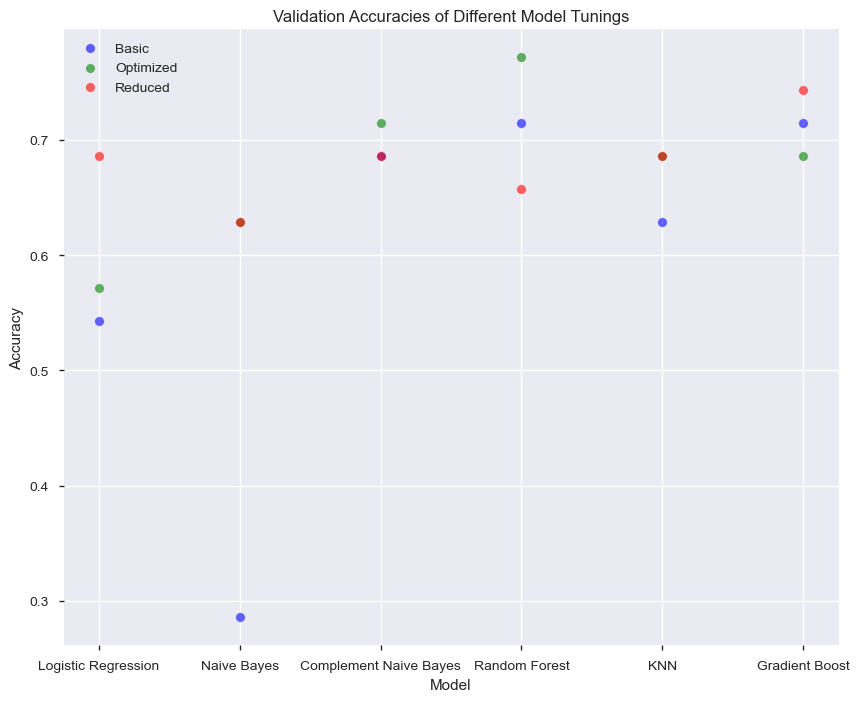

In [56]:
# Plot the validation set accuracies
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.scatterplot(data=df_valid.reset_index(), x="index", y="Basic", color="blue", alpha=0.6, label="Basic", ax=ax)
sns.scatterplot(data=df_valid.reset_index(), x="index", y="Optimized", color="green", alpha=0.6, label="Optimized", ax=ax)
sns.scatterplot(data=df_valid.reset_index(), x="index", y="Reduced", color="red", alpha=0.6, label="Reduced", ax=ax)

ax.set_title("Validation Accuracies of Different Model Tunings")
ax.set_ylabel("Accuracy")
ax.set_xlabel("Model")
ax.legend()

In [57]:
# Select the best version of each model to be the "final"
# If tied, then pick the simpler model.
final_lr = lr_red
final_nb = nb_red
final_nbc = nbc_grid
final_rf = rf_grid
final_knn = knn_red
final_boost = boost_red

# Conclusions

We have the optimal versions of all of our models, let's see how they perform on the test set.

In [59]:
# Compare the final model's accuracy on the training, validation and test sets
# Define a function to compute accurcies
def get_accs(model, X_train, X_valid, X_test, y_train, y_valid, y_test):    
    train_preds = model.predict(X_train)
    train_acc = accuracy_score(train_preds, y_train)
    
    valid_preds = model.predict(X_valid)
    valid_acc = accuracy_score(valid_preds, y_valid)
    
    test_preds = model.predict(X_test)
    test_acc = accuracy_score(test_preds, y_test)
    
    return(train_acc, valid_acc, test_acc)

# Used the reduced model for all the final models
lr_accs = get_accs(final_lr, X_train_red, X_valid_red, X_test_red, y_train, y_valid, y_test)
nb_accs = get_accs(final_nb, X_train_red, X_valid_red, X_test_red, y_train, y_valid, y_test)
rf_accs = get_accs(final_rf, X_train, X_valid, X_test, y_train, y_valid, y_test)
knn_accs = get_accs(final_knn, X_train_red, X_valid_red, X_test_red, y_train, y_valid, y_test)
nbc_accs = get_accs(final_nbc, X_train, X_valid, X_test, y_train, y_valid, y_test)
boost_accs = get_accs(final_boost, X_train_red, X_valid_red, X_test_red, y_train, y_valid, y_test)

In [60]:
index = ['Logistic Regression', 'Naive Bayes', 'Complement Naive Bayes', 'Random Forest', 'KNN', 'Gradient Boost']
df_results = pd.DataFrame([lr_accs, nb_accs, nbc_accs, rf_accs, knn_accs, boost_accs], 
                          columns=["train", "valid", "test"],
                          index=index)
df_results

,train,valid,test
Logistic Regression,0.683824,0.685714,0.534884
Naive Bayes,0.625000,0.628571,0.441860
Complement Naive Bayes,0.558824,0.714286,0.372093
Random Forest,1.000000,0.771429,0.558140
KNN,0.698529,0.685714,0.604651
Gradient Boost,1.000000,0.742857,0.604651


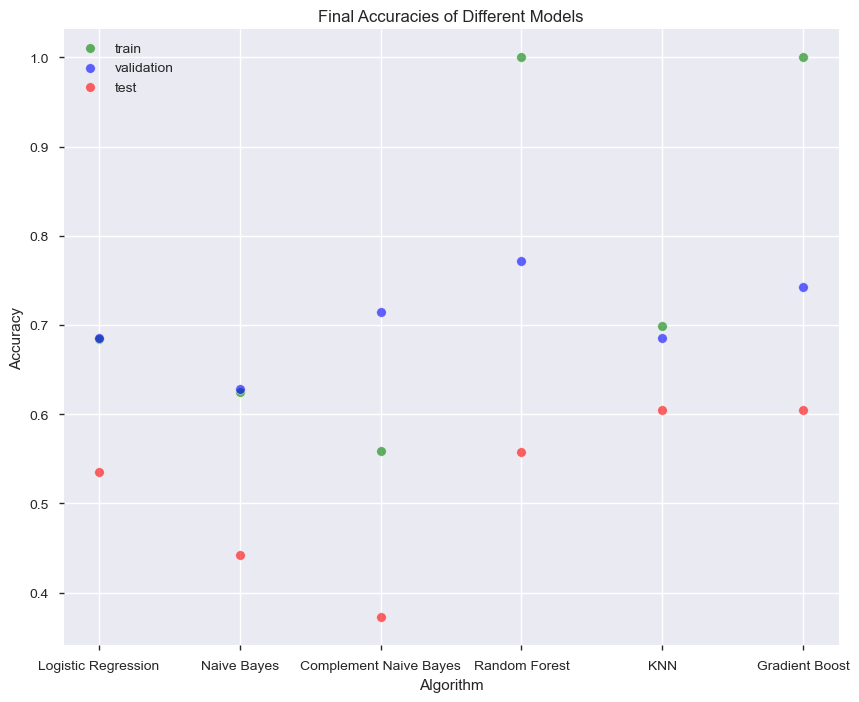

In [61]:
# Plot the results
fig, ax = plt.subplots(1, 1, figsize=(10, 8))

sns.scatterplot(data=df_results.reset_index(), x="index", y="train", color="green", alpha=0.6, label="train", ax=ax)
sns.scatterplot(data=df_results.reset_index(), x="index", y="valid", color="blue", alpha=0.6, label="validation", ax=ax)
sns.scatterplot(data=df_results.reset_index(), x="index", y="test", color="red", alpha=0.6, label="test", ax=ax)

ax.set_title("Final Accuracies of Different Models")
ax.set_xlabel("Algorithm")
ax.set_ylabel("Accuracy")
ax.legend()